# RVP Toolkit Demo

This notebook walks through the RVP toolkit step by step, using US Census income data using the [Folktables](https://github.com/socialfoundations/folktables) API.

The setting is stylized: a program targets cash transfers to low-income individuals using predicted income. The goal is to demonstrate the toolkit's functionality.

## 1. Data Setup

We load ACS Census data, train a simple income prediction model, and prepare the data for the toolkit.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from folktables import ACSDataSource, ACSIncome
from folktables.acs import adult_filter
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Load ACS data for California
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
filtered = adult_filter(acs_data)

X = np.nan_to_num(filtered[ACSIncome.features].values, nan=-1)
y = filtered['PINCP'].values.astype(float)
print(f"{len(y):,} individuals, median income ${np.median(y):,.0f}")

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f"R² = {model.score(X_test, y_test):.3f}")

R² = 0.414


## 2. Building an Allocation Problem

An `AllocationProblem` has four components. We build each one step by step.

In [52]:
from rvp import AllocationData, AllocationProblem
from rvp.utilities import CRRAUtility
from rvp.constraints import CoverageConstraint
from rvp.policies import RankingPolicy

**AllocationData** wraps predictions and ground truth outcomes into a single object.

In [6]:
df = pd.DataFrame({'predictions': preds, 'ground_truth': y_test})
data = AllocationData(df=df)
print(f"{data.n:,} individuals")

58,700 individuals


**Utility function** denotes how we value outcomes. CRRA utility captures diminishing returns: a $100 transfer matters more to someone earning $10K than $100K.

In [8]:
utility = CRRAUtility(rho=3.0, b=100)  # rho=3 (moderate risk aversion), b=100 (transfer size)

**Resource constraint** The program can treat a fixed fraction of the population.

In [9]:
constraint = CoverageConstraint(max_coverage=0.10, population_size=data.n)  # treat 10%
print(f"Capacity: {constraint.get_capacity():.0f} individuals")

Capacity: 5870 individuals


**Policy** How predictions map to allocations. We rank by predicted income and allocate to the lowest (ascending = poorest first).

In [10]:
policy = RankingPolicy(ascending=True)  # target lowest predicted income

**Combine into an AllocationProblem** and evaluate:

In [11]:
problem = AllocationProblem(data=data, utility=utility, constraint=constraint, policy=policy)

results = problem.evaluate()
print(f"Utility ratio: {results['utility_ratio']:.3f}")
print(f"  (= {results['utility_ratio']:.3f} times of random allocation welfare is achieved by predicted targeting)")

Utility ratio: 7.823
  (= 7.823 times of random allocation welfare is achieved by predicted targeting)


## 3. Policy Levers

Levers modify the allocation problem. Most levers have a parameter `theta` that controls its intensity. Calling `lever.apply(problem)` returns a *new* problem with the lever applied.

In [12]:
from rvp.levers import ExpandCoverageLever, CRRABenefitLever, PredictionImprovementLever

# Expand coverage by 5 percentage points
capacity_lever = ExpandCoverageLever(
    name="Capacity", coverage_increase=0.05, marginal_cost_per_person=500
)
expanded_problem = capacity_lever.apply(problem)
print(f"Before: {problem.constraint.get_capacity():.0f} beneficiaries")
print(f"After:  {expanded_problem.constraint.get_capacity():.0f} beneficiaries")
print(f"Total Utility: {problem.evaluate()['total_utility']} → {expanded_problem.evaluate()['total_utility']}")
print(f"Utility ratio: {problem.evaluate()['utility_ratio']:.3f} → {expanded_problem.evaluate()['utility_ratio']:.3f}")

Before: 5870 beneficiaries
After:  8805 beneficiaries
Total Utility: 0.0012175406009665136 → 0.0013162290726584636
Utility ratio: 7.823 → 5.638


## 4. Welfare Curves

How does welfare change as we vary a single lever's intensity?

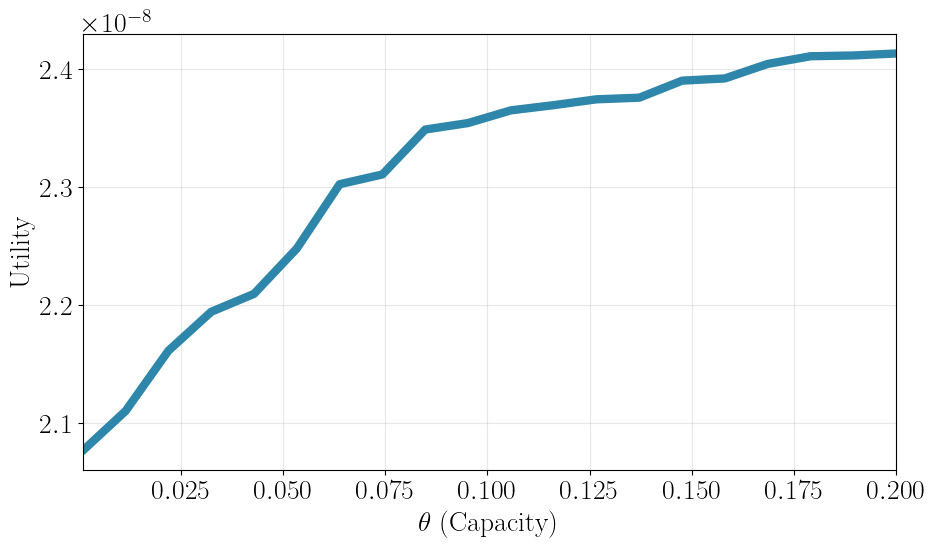

In [20]:
from rvp.comparison import plot_welfare_curve

capacity_lever = ExpandCoverageLever(
    name="Capacity", coverage_increase=0.0, marginal_cost_per_person=500
)

ax = plot_welfare_curve(
    problem, capacity_lever,
    theta_range=(1e-3, 0.2),
    n_points=20,
    welfare_metric='mean_utility',
    ylabel='Utility',
    show_baseline=True,
)

## 5. Comparing Two Levers

The `LeverComparison` class compares two levers against each other. This is useful when costs are uncertain. We can ask "how much improvement in predictions is equivalent to a given capacity expansion?"

The `PredictionImprovementLever` interpolates predictions toward ground truth: at `error_reduction=0` predictions are unchanged, at `error_reduction=1` they are perfect.

In [21]:
from rvp.comparison import LeverComparison

prediction_lever = PredictionImprovementLever(name="Prediction", error_reduction=0.3)
capacity_lever = ExpandCoverageLever(
    name="Capacity", coverage_increase=0.05, marginal_cost_per_person=500
)

comparison = LeverComparison(problem, lever_a=prediction_lever, lever_b=capacity_lever)

**Welfare difference**: as we sweep prediction improvement (lever A), how does its welfare compare to a fixed capacity expansion (lever B)?

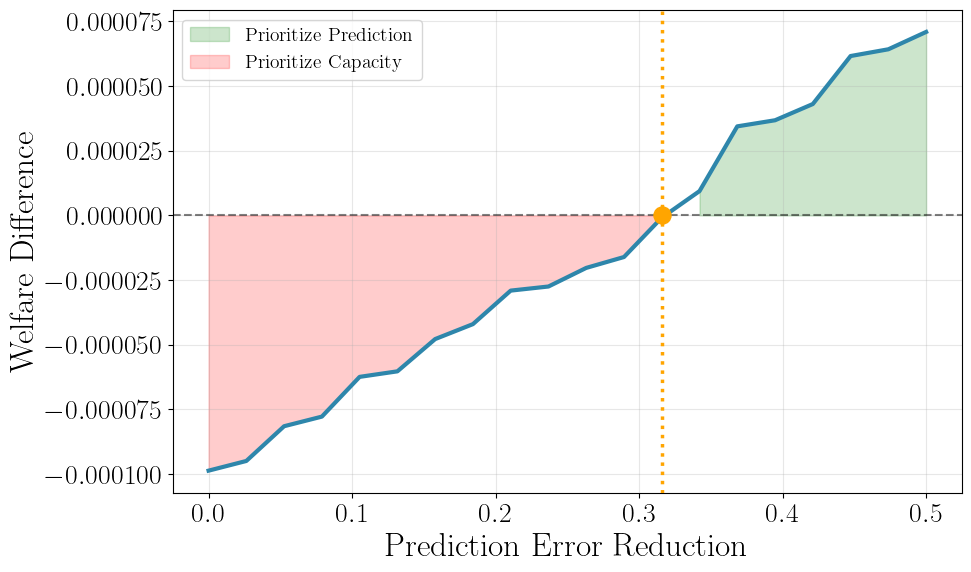

In [25]:
ax = comparison.plot_welfare_difference(
    theta_range=(0.0, 0.5),
    swept_lever='a',
    n_points=20,
    xlabel='Prediction Error Reduction'
)

**Equivalent cost**: for each level of prediction improvement, what capacity budget would achieve the same welfare?

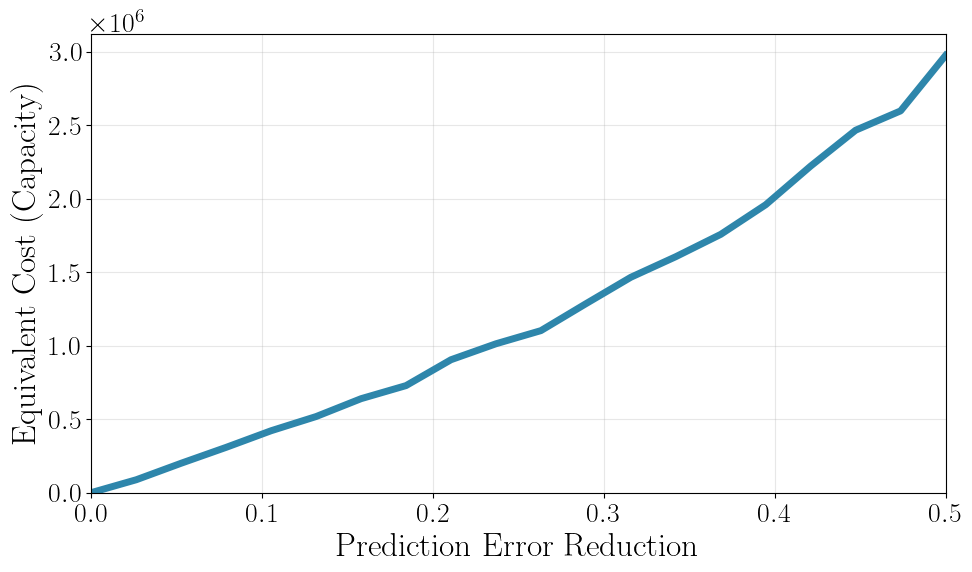

In [26]:
ax = comparison.plot_equivalent_cost(
    theta_range=(0.0, 0.5),
    swept_lever='a',
    n_points=20,
    reference_theta_search_range=(0.0, 0.5),
    xlabel='Prediction Error Reduction'
)

**Welfare heatmap**: how do both levers compare across their full parameter ranges?

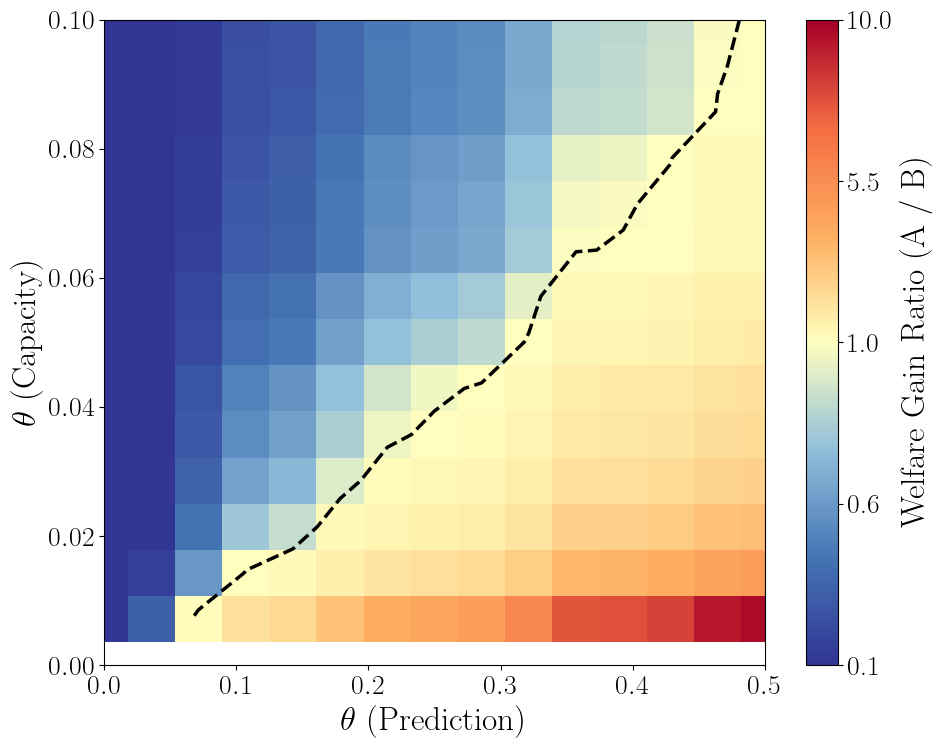

In [27]:
ax = comparison.plot_welfare_heatmap(
    theta_a_range=(0.0, 0.5),
    theta_b_range=(0.0, 0.1),
    n_points_a=15,
    n_points_b=15,
    vmin=0.1,
    vmax=10
)

## 6. Budget Optimization

When costs are known for all levers, we can find the optimal budget allocation. `optimize_budget_allocation` grid-searches over budget splits across any number of levers.

Here we start from a problem where only 20% of the population has been labeled (has usable predictions). The question is: spend budget on labeling more people at test time (improving targeting accuracy) or expanding program capacity?

In [39]:
from rvp.levers import DataLabelingLever
from rvp.comparison import optimize_budget_allocation, plot_budget_shares, plot_budget_thetas

BASELINE_LABEL_SHARE = 0.2

# Apply data labeling at baseline to create the starting problem (only 20% labeled)
dl_baseline = DataLabelingLever.from_data(
    data=data, name="Data collection", label_share=BASELINE_LABEL_SHARE,
    cost_per_label=50.0, ascending=True, marginal=False,
)
problem_partial = dl_baseline.apply(problem)
print(f"Baseline with {BASELINE_LABEL_SHARE:.0%} labeled:")
print(f"  Utility ratio: {problem_partial.evaluate()['utility_ratio']:.3f}")
print(f"  (vs full labels: {problem.evaluate()['utility_ratio']:.3f})")

# Marginal levers for optimization
datalabeling_lever = DataLabelingLever.from_data(
    data=data, name="Data collection", label_share=0.0,
    cost_per_label=15.0, ascending=True,
    baseline_share=BASELINE_LABEL_SHARE, marginal=True,
)

capacity_lever = ExpandCoverageLever(
    name="Capacity", coverage_increase=0.0, marginal_cost_per_person=utility.b,
)

Baseline with 20% labeled:
  Utility ratio: 2.625
  (vs full labels: 7.823)


In [46]:
58700*0.9*100

5283000.0

Budget 20/20: $5000000


<AxesSubplot: xlabel='Budget', ylabel='Budget Share'>

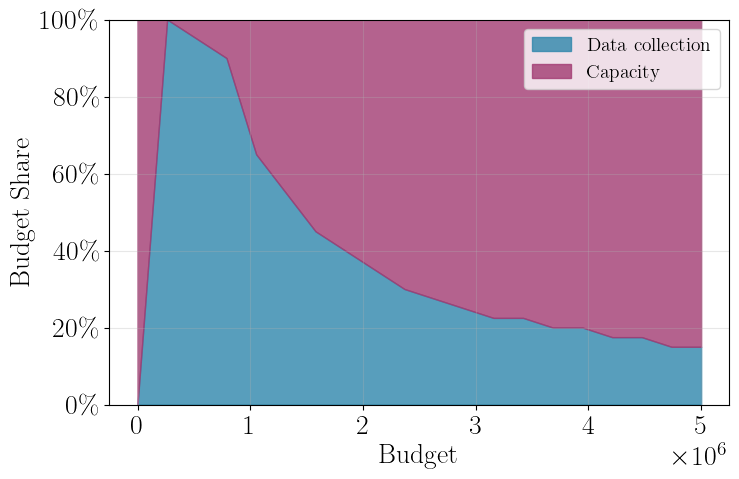

In [47]:
results_2 = optimize_budget_allocation(
    problem_partial,
    levers=[datalabeling_lever, capacity_lever],
    budget_range=(1, 5_000_000),
    n_budget_points=20,
    grid_density=40,
    verbose=True,
)

plot_budget_shares(results_2, stacked=True, labels=['Data collection', 'Capacity'])

`plot_budget_thetas` shows the optimal lever parameter at each budget level (one figure per lever):

[<AxesSubplot: title={'center': 'Data collection'}, xlabel='Budget', ylabel='Additional label share'>,
 <AxesSubplot: title={'center': 'Capacity'}, xlabel='Budget', ylabel='Coverage increase'>]

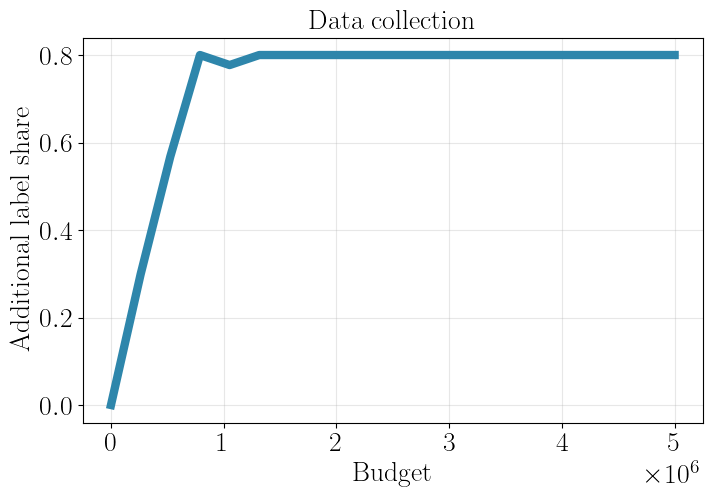

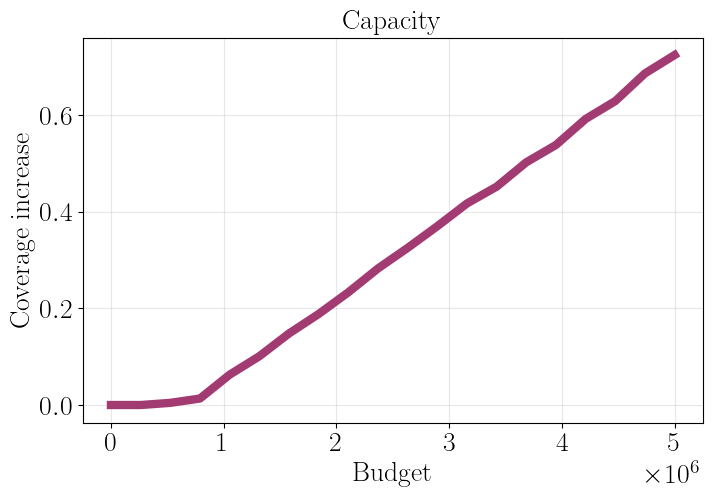

In [48]:
plot_budget_thetas(
    results_2,
    ylabels=['Additional label share', 'Coverage increase'],
)